In [1]:
import torch
import torch.nn as nn
import torch.optim as optim


import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import Cityscapes
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


from google.colab import drive
drive.mount('/content/drive')


Using PyTorch version: 2.2.1+cu121
Using GPU, device name: Tesla V100-SXM2-16GB
Mounted at /content/drive


In [2]:
## some model paths for checkpointing
## So downstream cells can pull
kitti_model_path_multiclass = '/content/drive/My Drive/kitti-multi-class.pth'
kitti_model_path_multiclass_losses = '/content/drive/My Drive/kitti-multi-class-losses.pth'

kitti_model_path_multiclass_attention = '/content/drive/My Drive/kitti-multi-attention-class.pth'
kitti_model_path_multiclass_attention_losses = '/content/drive/My Drive/kitti-multi-class-attention-losses.pth'


In [3]:
!git clone https://github.com/krmerchant/jhu_midterm.git
!cd jhu_midterm
!git checkout final-report


Cloning into 'jhu_midterm'...
remote: Enumerating objects: 279, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 279 (delta 13), reused 24 (delta 10), pack-reused 251
Receiving objects: 100% (279/279), 5.50 MiB | 27.90 MiB/s, done.
Resolving deltas: 100% (151/151), done.
fatal: not a git repository (or any of the parent directories): .git


(512, 512)
159
40
159
39
20
20


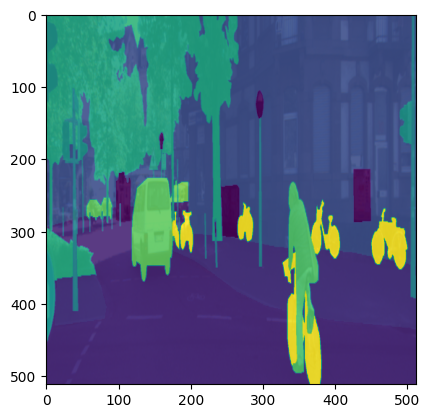

In [4]:
# @title Inspecting Kitti Dataset

import os
import torch
import pandas as pd
from skimage import io
from torch.utils.data import Dataset
from torchvision import transforms, utils
import torch.nn.functional as F

import sys
sys.path.append('/content/jhu_midterm/src')

from datasets import KittiDataset


kitti = KittiDataset('dataset.csv', '/content/drive/MyDrive/data/kitti_semantic/training',  transform=transforms.Compose([
        transforms.Resize((512, 512))
    ]))

image, seg = kitti[1]
numpy_image = image.permute(1, 2, 0).numpy()
numpy_seg = seg.reshape(seg.shape[1], seg.shape[2]).numpy()
print(numpy_seg.shape)
fig, ax = plt.subplots(1, 1)
ax.imshow((numpy_image))
seg_map = ax.imshow(numpy_seg,alpha=0.9)



## gotta split into sets
## 80% train, 10% val, 10% test
train_size = int(0.8 * len(kitti))
val_size = (len(kitti) - train_size)
test_size = (len(kitti) - train_size)/2
train_dataset, val_dataset = torch.utils.data.random_split(kitti, [train_size, val_size])
print(len(train_dataset))
print(len(val_dataset))


val_dataset, test_dataset = torch.utils.data.random_split(val_dataset, [int(test_size), int(test_size)])



# Create data loaders to iterate through the datasets in batches
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 4, shuffle=True, drop_last = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, shuffle=False)


print(len(train_loader.sampler))
print(len(train_loader))
print(len(val_loader.sampler))
print(len(test_loader.sampler))



In [8]:
# @title Computing Class Imbalance Scores and Processing Per-Class Frequency
from collections import defaultdict
class_frequencies = defaultdict(int)

total_samples = 0;
# Iterate through the dataloader
for images, masks in train_loader:
    # masks is a tensor of shape (batch_size, height, width)

    # Flatten the masks and count class occurrences
    masks_flat = masks.view(-1)  # Flatten the masks tensor
    unique_classes, counts = torch.unique(masks_flat, return_counts=True)
    total_samples += counts.sum().item()
    # Update the counter
    for cls, count in zip(unique_classes, counts):
        class_frequencies[int(cls)] += int(count)

class_frequencies = sorted(class_frequencies.items())

per_class_freq = torch.zeros(34)
weight_tensor = torch.zeros(34)
print(weight_tensor.shape)
# Print the class frequencies
for cls, freq in class_frequencies:
    print(f"Class {cls}: freq {freq}")
    per_class_freq[cls] = freq


weight_tensor = 1/per_class_freq;
print(weight_tensor)

torch.Size([34])
Class 0: freq 2324
Class 1: freq 222
Class 2: freq 333
Class 3: freq 162
Class 4: freq 371150
Class 5: freq 33102
Class 6: freq 91882
Class 7: freq 9231577
Class 8: freq 1622442
Class 9: freq 312612
Class 10: freq 244270
Class 11: freq 3097299
Class 12: freq 362151
Class 13: freq 314830
Class 14: freq 319107
Class 15: freq 77544
Class 16: freq 243261
Class 17: freq 397006
Class 18: freq 144609
Class 19: freq 238315
Class 20: freq 387669
Class 21: freq 12568881
Class 22: freq 3897763
Class 23: freq 4268516
Class 24: freq 55468
Class 25: freq 44128
Class 26: freq 2250509
Class 27: freq 92986
Class 28: freq 33571
Class 29: freq 5647
Class 30: freq 50294
Class 31: freq 108853
Class 32: freq 4368
Class 33: freq 21613
tensor([4.3029e-04, 4.5045e-03, 3.0030e-03, 6.1728e-03, 2.6943e-06, 3.0210e-05,
        1.0884e-05, 1.0832e-07, 6.1635e-07, 3.1989e-06, 4.0938e-06, 3.2286e-07,
        2.7613e-06, 3.1763e-06, 3.1337e-06, 1.2896e-05, 4.1108e-06, 2.5189e-06,
        6.9152e-06, 4

In [ ]:
# @title Train Kitti with WCE Loss

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import os
from models import UNet
import pickle
from eval_tools import LossTracker

model = UNet(34, debug=False).to(device)

criterion = nn.CrossEntropyLoss(weight=weight_tensor).to(device)
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)  ## set optimizer we're usin
scheduler = ReduceLROnPlateau(optimizer, 'min')
epochs = 300

lt = LossTracker()
best_loss = 1000;
for epoch in range(0,epochs):


  # #TRAINING
  model.train()
  losses = np.array([])
  for i, (images, labels) in (enumerate(train_loader)):
    images = images.to(device)
    labels = torch.squeeze(labels.to(device))
    #forward pass
    pred_labels = model(images.float()).to(device);
    #print(f"{pred_labels=}")
    loss = criterion(pred_labels.to(device), labels.to(device))

    ##optim
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



    losses = np.append(losses,loss.item())
    print(f"Epoch [{epoch}/{epochs}], Step [{i}/{len(train_loader)}], Train Loss {loss}")
    del images,labels, pred_labels



  train_loss = np.mean(losses) #average losses over all batches
  lt.add_loss('train',train_loss)


  #VALIDATION
  model.eval()
  total_samples =0;
  correct_samples = 0
  validation_losses = np.array([])
  with torch.no_grad():
    for(images, labels) in val_loader:
      images = images.to(device)
      labels = torch.squeeze(labels.to(device))
      #forward pass
      pred_labels = model(images.float()).to(device);
      #print(f"{pred_labels=}")
      loss = criterion(pred_labels.to(device), labels.to(device))

      predicted = torch.argmax(pred_labels.squeeze(),1) ##using
      print(f"{predicted.shape=}")

      total_samples += labels.numel();
      correct_samples += (predicted == labels).sum().item()
      validation_losses = np.append(validation_losses,loss.item())


      del images, pred_labels,labels



  val_loss = np.mean(validation_losses)
  lt.add_loss('validation',val_loss)
  if(val_loss < best_loss):
    print(' Saving model ...')
    torch.save(model.state_dict(), kitti_model_path_multiclass)
    best_loss = val_loss

  with open(kitti_model_path_multiclass_losses, 'wb') as handle:
    pickle.dump(lt.losses, handle, protocol=pickle.HIGHEST_PROTOCOL)
  lr = optimizer.state_dict()["param_groups"][0]["lr"]
  print(f"Epoch [{epoch}/{epochs}], Train Loss {train_loss}, Validation Loss {val_loss}, Accuracy: {correct_samples/total_samples}, LR: {lr}")
  scheduler.step(val_loss)



In [ ]:
# @title Train Kitti with WCE Loss + Attention UNet

import torch
import torch.nn as nn
import torch.optim as optim

from models import AttentionUNet
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import os
from models import UNet
import pickle
from eval_tools import LossTracker

model = AttentionUNet(34, debug=False).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)  ## set optimizer we're usin
scheduler = ReduceLROnPlateau(optimizer, 'min')
epochs = 300

lt = LossTracker()
best_loss = 1000;
for epoch in range(0,epochs):


  # #TRAINING
  model.train()
  losses = np.array([])
  for i, (images, labels) in (enumerate(train_loader)):
    images = images.to(device)
    labels = torch.squeeze(labels.to(device))
    #forward pass
    pred_labels = model(images.float()).to(device);
    #print(f"{pred_labels=}")
    loss = criterion(pred_labels.to(device), labels.to(device))

    ##optim
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



    losses = np.append(losses,loss.item())
    print(f"Epoch [{epoch}/{epochs}], Step [{i}/{len(train_loader)}], Train Loss {loss}")
    del images,labels, pred_labels



  train_loss = np.mean(losses) #average losses over all batches
  lt.add_loss('train',train_loss)


  #VALIDATION
  model.eval()
  total_samples =0;
  correct_samples = 0
  validation_losses = np.array([])
  with torch.no_grad():
    for(images, labels) in val_loader:
      images = images.to(device)
      labels = torch.squeeze(labels.to(device))
      #forward pass
      pred_labels = model(images.float()).to(device);
      #print(f"{pred_labels=}")
      loss = criterion(pred_labels.to(device), labels.to(device))

      predicted = torch.argmax(pred_labels.squeeze(),1) ##using
      print(f"{predicted.shape=}")

      total_samples += labels.numel();
      correct_samples += (predicted == labels).sum().item()
      validation_losses = np.append(validation_losses,loss.item())


      del images, pred_labels,labels



  val_loss = np.mean(validation_losses)
  lt.add_loss('validation',val_loss)
  if(val_loss < best_loss):
    print(' Saving model ...')
    torch.save(model.state_dict(), kitti_model_path_multiclass_attention)
    best_loss = val_loss

  with open(kitti_model_path_multiclass_attention_losses, 'wb') as handle:
    pickle.dump(lt.losses, handle, protocol=pickle.HIGHEST_PROTOCOL)
  lr = optimizer.state_dict()["param_groups"][0]["lr"]
  print(f"Epoch [{epoch}/{epochs}], Train Loss {train_loss}, Validation Loss {val_loss}, Accuracy: {correct_samples/total_samples}, LR: {lr}")
  scheduler.step(val_loss)



Epoch [0/300], Step [0/39], Train Loss 3.5263047218322754
Epoch [0/300], Step [1/39], Train Loss 3.5265889167785645
Epoch [0/300], Step [2/39], Train Loss 3.528066635131836
Epoch [0/300], Step [3/39], Train Loss 3.526547431945801
Epoch [0/300], Step [4/39], Train Loss 3.527127981185913
Epoch [0/300], Step [5/39], Train Loss 3.525482416152954
Epoch [0/300], Step [6/39], Train Loss 3.526766300201416
Epoch [0/300], Step [7/39], Train Loss 3.5262298583984375


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

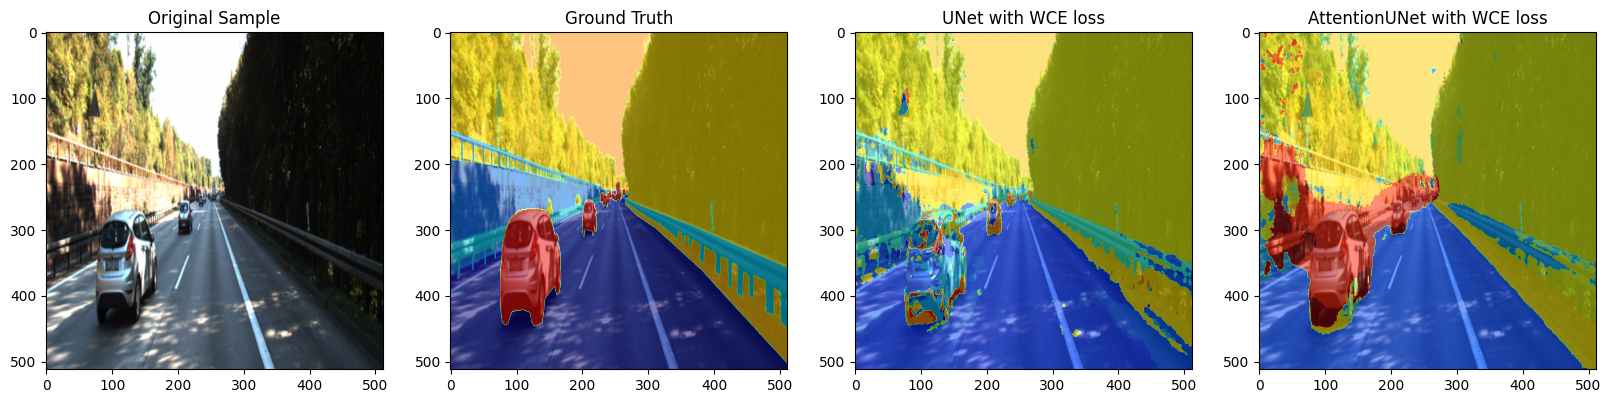

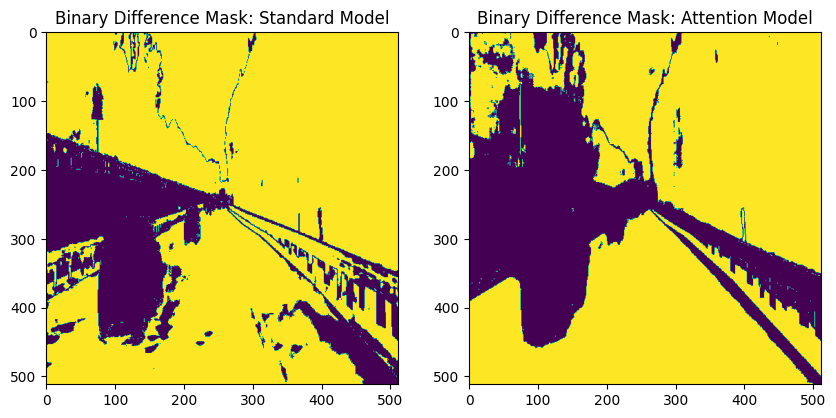

In [6]:
# @title Qualitative Ground Truth Analysis
from models import UNet
from models import AttentionUNet
image, seg = test_dataset[3];
[c,w,h] = image.shape
image = image.reshape([1,c,w,h])

standard_model = UNet(34 ).to(device)
standard_model.load_state_dict(torch.load(kitti_model_path_multiclass, map_location=device))
standard_model.eval()
output_standard = torch.argmax(standard_model(image.to(device)),1)

attention_model = AttentionUNet(34).to(device)
attention_model.load_state_dict(torch.load(kitti_model_path_multiclass_attention, map_location=device))
attention_model.eval()
output_attention_model = torch.argmax(attention_model(image.to(device)),1)



fig,ax = plt.subplots(1,4, figsize=(20,20));
image = image.squeeze().permute(1, 2, 0).numpy();
ax[0].imshow(image)
ax[0].set_title('Original Sample')

ax[1].imshow(image)
ax[1].imshow(seg.squeeze(), cmap='jet', alpha=0.5);
ax[1].set_title('Ground Truth')
seg_im = output_standard.cpu().detach()
ax[2].imshow(image)
ax[2].imshow(seg_im.squeeze(), cmap='jet', alpha=0.5);
ax[2].set_title('UNet with WCE loss')
seg_im = output_attention_model.cpu().detach()
ax[3].imshow(image)
ax[3].imshow(seg_im.squeeze(), cmap='jet', alpha=0.5);
ax[3].set_title('AttentionUNet with WCE loss')

plt.savefig('test_sample.png')
from google.colab import files
files.download('test_sample.png')


fig_diff,ax_diff = plt.subplots(1,2, figsize=(10,10));

seg_im = output_standard.cpu().detach() == seg.squeeze()
ax_diff[0].imshow(seg_im.squeeze());
ax_diff[0].set_title('Binary Difference Mask: Standard Model')


seg_im = output_attention_model.cpu().detach() == seg.squeeze()
ax_diff[1].imshow(seg_im.squeeze());
ax_diff[1].set_title('Binary Difference Mask: Attention Model')



plt.savefig('test_sample_diff_mask.png')
from google.colab import files
files.download('test_sample_diff_mask.png')


In [12]:
# @title Plot Training Curves From Kitti Dataset
import pickle
from eval_tools import LossTracker

lt = LossTracker()
with open(kitti_model_path_multiclass_losses, "rb") as myFile:
    myNewPulledInDictionary = pickle.load(myFile)
lt.losses = myNewPulledInDictionary
lt.plot_loss_curves()
plt.title(f"Loss Curves: AttentionUNet")

plt.savefig('loss.png')
from google.colab import files
files.download('loss.png')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/kitti-multi-class-losses.pth'

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

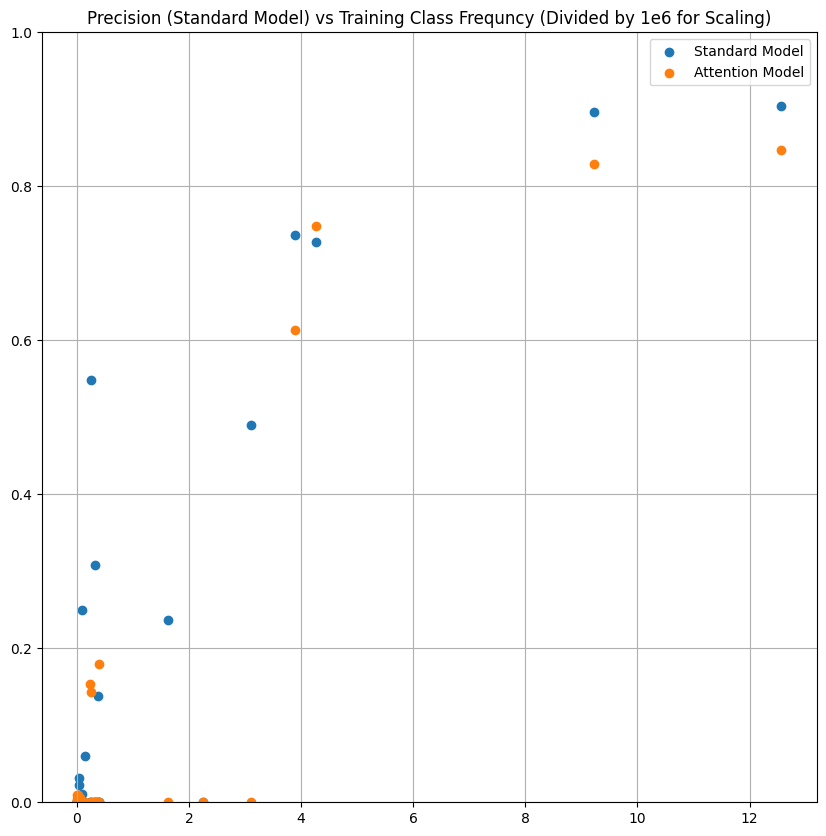

In [9]:
# @title Generate Ground Truth Statistics

def generator_pred_vector(model, data_loader):
  pred_labels_stack = np.array([])
  gt_labels_stack = np.array([])
  for(image, seg) in data_loader:
    pred_labels = model(image.to(device));
    pred_labels = torch.argmax(pred_labels,1).view(-1)
    pred_labels_stack = np.append(pred_labels_stack,pred_labels.cpu().numpy())
    gt_labels_stack = np.append(gt_labels_stack, seg.view(-1).numpy())

  return pred_labels_stack, gt_labels_stack;

from eval_tools import GroundTruthStatsClass
from models import UNet
import sklearn.metrics as metrics
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score


standard_model = UNet(34).to(device)
standard_model.load_state_dict(torch.load(kitti_model_path_multiclass, map_location=device))
standard_model.eval()
p,g = generator_pred_vector(standard_model,test_loader)
# Compute the confusion matrix
conf_matrix = confusion_matrix(g, p)
# Compute per-class precision
# average=None returns precision for each class separately
per_class_precision = precision_score(g, p, average=None)
# Compute per-class recall
# average=None returns recall for each class separately
per_class_recall = recall_score(g, p, average=None)

attention_model = AttentionUNet(34).to(device)
attention_model.load_state_dict(torch.load(kitti_model_path_multiclass_attention, map_location=device))
attention_model.eval()
p_att,g_att = generator_pred_vector(attention_model,test_loader)
# Compute the confusion matrix
conf_matrix_att = confusion_matrix(g_att, p_att)
# Compute per-class precision
# average=None returns precision for each class separately
per_class_precision_att = precision_score(g_att, p_att, average=None)
# Compute per-class recall
# average=None returns recall for each class separately
per_class_recall_att = recall_score(g_att, p_att, average=None)





#fig,ax =  plt.subplots(1,2, figsize=(10,10))
#ax[0].scatter(per_class_freq/1e6,per_class_precision, c=range(0,len(per_class_freq)) , cmap='viridis')
#ax[0].set_title('Precision (Standard Model) vs Training Class Frequncy (Divided by 1e6 for Scaling)')
#ax[0].grid(True)
#
#ax[1].scatter(per_class_freq/1e6,per_class_precision_att, c=range(0,len(per_class_freq)) , cmap='viridis')
#ax[1].set_title('Precision (Standard Model) vs Training Class Frequncy (Divided by 1e6 for Scaling)')
#ax[1].grid(True)
#plt.axis('equal')






fig_comp,ax_comp =  plt.subplots(1, figsize=(10,10))
ax_comp.scatter(per_class_freq/1e6,per_class_precision, label='Standard Model')
ax_comp.scatter(per_class_freq/1e6,per_class_precision_att, label='Attention Model')
ax_comp.set_title('Precision (Standard Model) vs Training Class Frequncy (Divided by 1e6 for Scaling)')
ax_comp.set_ylim(0,1)
ax_comp.grid(True)
ax_comp.legend()

plt.savefig('prec_vs_traing.png')
from google.colab import files
files.download('prec_vs_traing.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

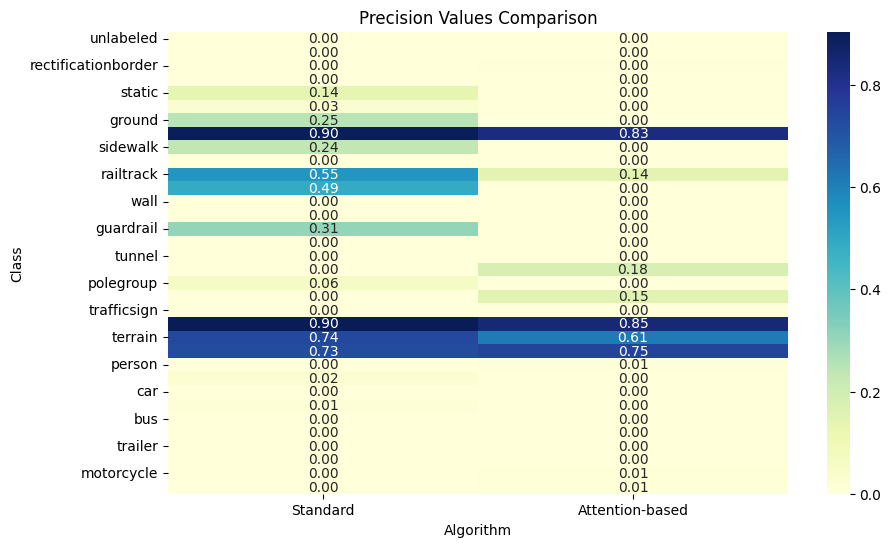

In [10]:
# @title Per-Class Recall Comparison
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Example class names (replace with your actual class names)
class_names = ['unlabeled','egovehicle','rectificationborder','outofroi','static','dynamic','ground','road','sidewalk','parking','railtrack','building','wall','fence','guardrail','bridge','tunnel','pole','polegroup','trafficlight','trafficsign','vegetation','terrain','sky','person','rider','car','truck','bus','caravan','trailer','train','motorcycle','bicycle']

# Create a DataFrame from the precision values for both algorithms
precision_df = pd.DataFrame({'Standard': per_class_precision, 'Attention-based': per_class_precision_att}, index=class_names)

# Create a heatmap table using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(precision_df, annot=True, cmap='YlGnBu', fmt='.2f', cbar=True)
plt.title('Precision Values Comparison')
plt.xlabel('Algorithm')
plt.ylabel('Class')


plt.savefig('prec_comp.png')
from google.colab import files
files.download('prec_comp.png')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

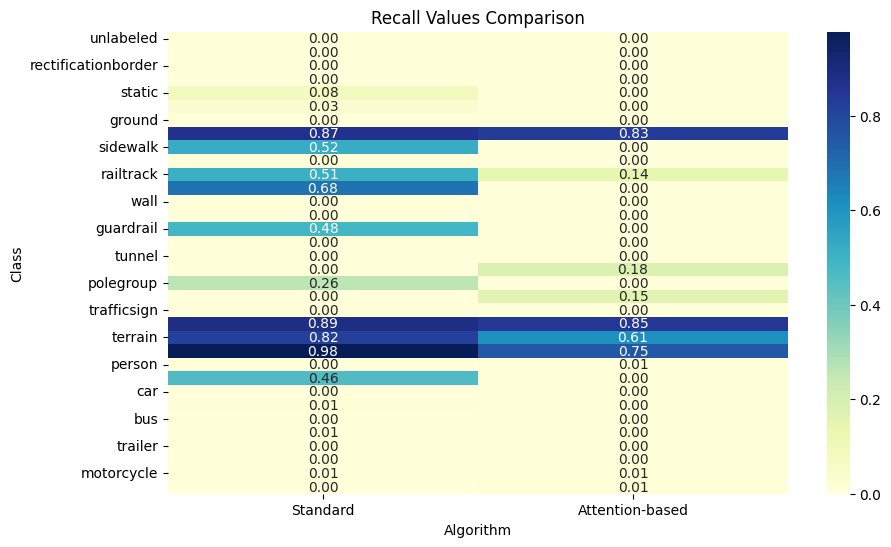

In [11]:
# @title Per-Class Precision Comparison
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Example class names (replace with your actual class names)
class_names = ['unlabeled','egovehicle','rectificationborder','outofroi','static','dynamic','ground','road','sidewalk','parking','railtrack','building','wall','fence','guardrail','bridge','tunnel','pole','polegroup','trafficlight','trafficsign','vegetation','terrain','sky','person','rider','car','truck','bus','caravan','trailer','train','motorcycle','bicycle']

# Create a DataFrame from the precision values for both algorithms
precision_df = pd.DataFrame({'Standard': per_class_recall, 'Attention-based': per_class_precision_att}, index=class_names)

# Create a heatmap table using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(precision_df, annot=True, cmap='YlGnBu', fmt='.2f', cbar=True)
plt.title('Recall Values Comparison')
plt.xlabel('Algorithm')
plt.ylabel('Class')

plt.savefig('recall_comp.png')
from google.colab import files
files.download('recall_comp.png')



In [ ]:

# Print per-class precision and recall
print("Per-class precision:")
for cls, precision in enumerate(per_class_precision_att):
    print(f"Class {cls}: {precision:.4f}")

print("\nPer-class recall:")
for cls, recall in enumerate(per_class_recall_att):
    print(f"Class {cls}: {recall:.4f}")

Per-class precision:
Class 0: 0.0000
Class 1: 0.0000
Class 2: 0.0000
Class 3: 0.0000
Class 4: 0.0000
Class 5: 0.0000
Class 6: 0.0000
Class 7: 0.7531
Class 8: 0.0000
Class 9: 0.0000
Class 10: 0.0648
Class 11: 0.0000
Class 12: 0.0000
Class 13: 0.0000
Class 14: 0.0000
Class 15: 0.0000
Class 16: 0.0000
Class 17: 0.0996
Class 18: 0.0000
Class 19: 0.0637
Class 20: 0.0000
Class 21: 0.8437
Class 22: 0.3996
Class 23: 0.8791
Class 24: 0.0159
Class 25: 0.0019
Class 26: 0.0417
Class 27: 0.0000
Class 28: 0.0000
Class 29: 0.0001
Class 30: 0.0000
Class 31: 0.0000
Class 32: 0.0000
Class 33: 0.0025

Per-class recall:
Class 0: 0.0000
Class 1: 0.0000
Class 2: 0.0000
Class 3: 0.0000
Class 4: 0.0000
Class 5: 0.0000
Class 6: 0.0000
Class 7: 0.8549
Class 8: 0.0000
Class 9: 0.0000
Class 10: 0.5665
Class 11: 0.0000
Class 12: 0.0000
Class 13: 0.0000
Class 14: 0.0000
Class 15: 0.0000
Class 16: 0.0000
Class 17: 0.2910
Class 18: 0.0000
Class 19: 0.1566
Class 20: 0.0000
Class 21: 0.7244
Class 22: 0.7553
Class 23: 0